# Explore Data

The simulator generates JPG images with dimensions 320x160x3, for 3 different camera positions labeled center, left and right, also time-stamped. The time stamp show that the average sample is around 10Hz. Below are a sample for this images.

### Define project specific python constants

In [1]:
SIMULATOR_DIR = "/home/porko/Descargas/simulator-linux/"
#SIMULATOR_DIR = "../simulator-linux/"
IMG_DIR       = SIMULATOR_DIR + "IMG/"
LABEL_CSV     = SIMULATOR_DIR + "driving_log.csv"
%pwd
%cd /home/porko/workspace/nd_selfDrive/CarND-Behavioral-Cloning-P3

/home/porko/workspace/nd_selfDrive/CarND-Behavioral-Cloning-P3



10492
(160, 320, 3)


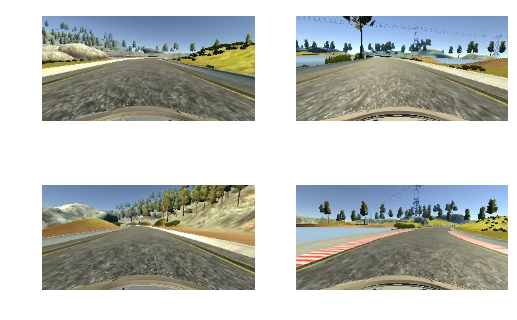

Done


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from glob import glob

center_imgs = glob(IMG_DIR+"center*")
print()
print(len(center_imgs))
center_arr = []
# Read only a sample of 10 images
for img in center_imgs[:4]:
    center_arr.append(mpimg.imread(img))

def plot_imgArr(img_arr, label=None, predict=None, gray=False):
    f, arr = plt.subplots(2,2)
    print(img_arr[0].shape)
    for n, subplt in enumerate(arr.reshape(-1)):
        if gray:
            subplt.imshow(img_arr[n],  cmap='gray')
        else:
            subplt.imshow(img_arr[n])
        subplt.axis('off')
        if label is not None and predict is None:
            subplt.set_title("steer: "+str(label[n]))
        elif label is not None and predict is not None:
            subplt.set_title("st:"+str(label[n]) + "p:"+str(predict[n]))
    plt.show()

plot_imgArr(center_arr)
print("Done")

In the images above we can se that some parts of it may not be of use for the network and may cause waste of time and memory resources. 
Then we can crop the upper part, and also part of the bottom where a part of the car is visible.

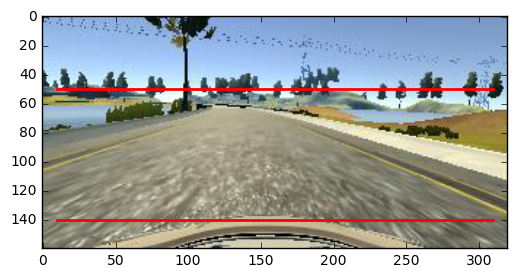

In [3]:
# select an image to visualize the region to crop
crop_img = plt.imread(center_imgs[1])
# Define the area of interest
BOTTOM_MARGIN = 50
TOP_MARGIN = 140
# Lines are defines as [x0, x1,...,xn], [y0, y1,...,yn]
plt.plot([10, 310], [BOTTOM_MARGIN, BOTTOM_MARGIN], 'r-', lw=2)
plt.plot([10, 310], [TOP_MARGIN, TOP_MARGIN], 'r-', lw=2)
plt.imshow(crop_img);
# Draw the crop lines

In the image the red lines indicate the new limit of the image, then we will apply this reduction to all the center images.

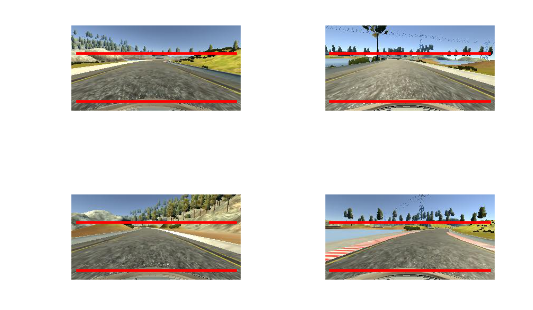

In [4]:
f, arr = plt.subplots(2,2)
for n, subplt in enumerate(arr.reshape(-1)):
    subplt.imshow(center_arr[n])
    subplt.axis('off')
    subplt.plot([10, 310], [BOTTOM_MARGIN, BOTTOM_MARGIN], 'r-', lw=2)
    subplt.plot([10, 310], [TOP_MARGIN, TOP_MARGIN], 'r-', lw=2)
plt.show()

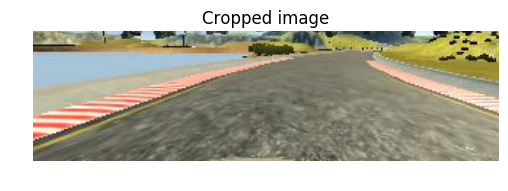

In [5]:
# apply the crop in all the images
import cv2
img = plt.imread(center_imgs[3])
crop_img = img[50:140]
plt.axis('off')
plt.title("Cropped image")
plt.imshow(crop_img);


#### Learning Note:
OpenCV reads the RGB colors in inverse order as maplotlib, this makes the image to look weird and possibly affects the recognition in the CNNs.
To solve this we need to, either use only OpenCV library or only Matplotlibs or reverse the color order in the array spending instructions.

http://www.pyimagesearch.com/2014/11/03/display-matplotlib-rgb-image/

# Analyze the generated CSV:

This is the content of the csv:
`center_img` | `left_img` | `rigth_img` | `steering_angle` | `throttle` | `Break` | `Speed`

In [6]:
import csv

labels_csv = csv.reader(open(LABEL_CSV, "r"))

steering_angles = []
center_imgs_path = []
left_imgs_path = []
rigth_imgs_path = []
data = {"center_path": center_imgs_path, "left_path":left_imgs_path, "rigth_path": rigth_imgs_path, "label":steering_angles}
for line in labels_csv:
    center_imgs_path.append(line[0])
    steering_angles.append(float(line[3]))

In the current project, our output is the steering angle. As we did in previous projects, we need to check if our data is well distributed, this way the model will be capable of better generalization in the future in comparison to skewed data.

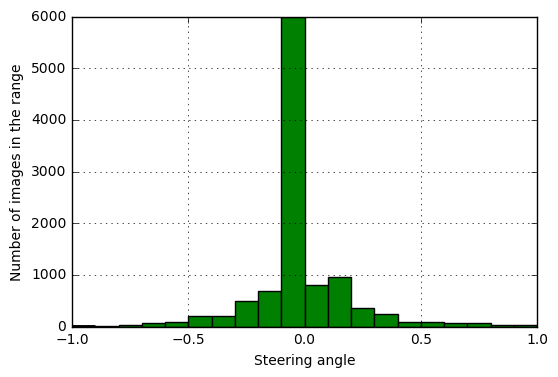

|n|:   11   n: -1.00 
|n|:    4   n: -0.90 
|n|:   21   n: -0.80 
|n|:   60   n: -0.70 
|n|:   95   n: -0.60 
|n|:  205   n: -0.50 
|n|:  206   n: -0.40 
|n|:  496   n: -0.30 
|n|:  689   n: -0.20 
|n|: 5998   n: -0.10 
|n|:  802   n: 0.00 
|n|:  950   n: 0.10 
|n|:  351   n: 0.20 
|n|:  244   n: 0.30 
|n|:   93   n: 0.40 
|n|:   91   n: 0.50 
|n|:   66   n: 0.60 
|n|:   65   n: 0.70 
|n|:   21   n: 0.80 
|n|:   24   n: 0.90 


In [7]:
n, bins, _ = plt.hist(steering_angles, facecolor='green',  bins=20)
plt.xlabel('Steering angle')
plt.ylabel('Number of images in the range')
plt.grid(True)
plt.show()

#convert n, which is in float to int. n indicates the number of elements in the bin

n = list(map(int, n))

for i, b in zip(n,bins):
    print("|n|: %4d   n: %.2f "% (i, b))
    

As described int the image is clear that our data is skewed by straigth driving samples. Then it's neccesary to balance the data, this will be done by getting more data
and also with data augmentation.

8
4
21
60
95
205
206
496
689
3256
704
950
351
244
93
91
66
65
21
0
negative images count: 1787
postivie images count: 1881
9351
9351
New negative images count: 2337.0
New postivie images count: 3144.0


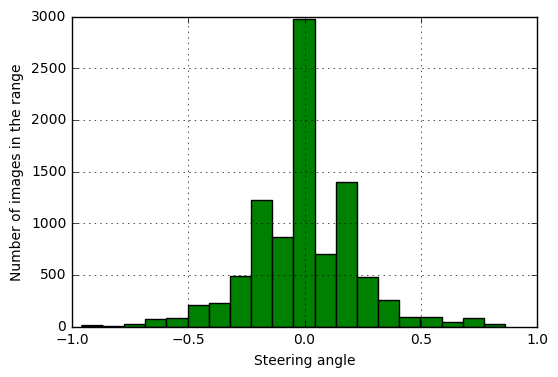

In [8]:
from PIL import Image
from PIL import ImageOps
import random
import cv2
# create list for data
X = [[] for _ in range(len(n))]
# create list for labels]
y = [[] for _ in range(len(n))]
random.seed(7)
# Transformtations to augment the data set
def mirror(image):
    mirr_img = cv2.flip(image,1)
    #label = label * -1. ## add little offset so the image is not exactly the same
    return (np.add(mirr_img, random.uniform (-0.3, 0.3) ))

def brightness(image):
    im = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    im[:,:,2] = np.multiply(im[:,:,2], .3+np.random.uniform())
    im = cv2.cvtColor(im,cv2.COLOR_HSV2RGB)
    return im


def translate(image):
    i = random
    M = np.float32([[1,0,random.randint(0,10)],[0,1,0]])
    return cv2.warpAffine(image,M,(image.shape[0],image.shape[1]))


for i, (lbl, img) in enumerate(zip(steering_angles, center_imgs_path)):
    if  -0.1 <= lbl <= 0.038 and random.random() >=0.2:
        steering_angles.pop(i)
        center_imgs_path.pop(i) 

# Separate the images in bins for augmentation
for label, data in zip(steering_angles, center_imgs_path):
    # Increase the data set.
    # crop data to our defined area of interest

    #X.append(plt.imread(SIMULATOR_DIR+ data)[BOTTOM_MARGIN:TOP_MARGIN])
    #X.append(np.asarray(Image.open(SIMULATOR_DIR+data).crop((0,BOTTOM_MARGIN,320,TOP_MARGIN))))
    #y.append(label)
    
    for b in range(len(n)-1):
        if bins[b] < label <= bins[b+1]:
            X[b].append(np.asarray(Image.open(SIMULATOR_DIR+data).crop((0,BOTTOM_MARGIN,320,TOP_MARGIN))))
            y[b].append(label)

            
for x in range(len(n)):
    print(len(X[x]))

    
#remove 40% of images with steering close to zero
for i, (lbl, img) in enumerate(zip(y[10], X[10])):
    if random.random() >=0.2:
        y[10].pop(i)
        X[10].pop(i) 

#Add more data by augmentation in each bin, first try to balance
        
for i, (lbl, img) in enumerate(zip(y[11], X[11])):
    if random.random() >=0.4:
        y[11].append((-1.*lbl) + random.uniform (-0.006, 0.006))
        X[11].append(mirror(img))

for i, (lbl, img) in enumerate(zip(y[8], X[8])):
    if random.random() >=0.7:
        y[20-8].append((-1.*lbl) +  random.uniform (-0.006, 0.006))
        X[20-8].append(mirror(img)) 
                
for i, (lbl, img) in enumerate(zip(y[13], X[13])):
    if random.random() >=0.5:
        y[20-13].append((-1.*lbl) + random.uniform (-0.006, 0.006))
        X[20-13].append(mirror(img)) 

for i, (lbl, img) in enumerate(zip(y[7], X[7])):
    if random.random() >=0.6:
        y[20-7].append((-1.*lbl) +  random.uniform (-0.006, 0.006))
        X[20-7].append(mirror(img)) 
            

            
for i, (lbl, img) in enumerate(zip(y[14], X[14])):
    if random.random() >=0.7:
        y[20-14].append((-1.*lbl) +  random.uniform (-0.006, 0.006))
        X[20-14].append(mirror(img)) 

for i, (lbl, img) in enumerate(zip(y[6], X[6])):
    if random.random() >=0.7:
        y[20-6].append((-1.*lbl) +  random.uniform (-0.006, 0.006))
        X[20-6].append(mirror(img)) 
            
            
#flat list of lists

X = sum(X, [])
y = sum(y, [])
        
neg_imgs = sum(n[0:9])
pos_imgs = sum(n[11:19])
print("negative images count: " + str(sum(n[0:9])) )
print("postivie images count: " + str(sum(n[11:19])) )
"""
ratio_np = neg_imgs/pos_imgs
print("ratio: " + str(ratio_np))
if ratio_np > 1.2:
    #noImgs = abs(int((len(X) * (1.0 - ratio_np)) )) - pos_imgs
    noImgs = neg_imgs - pos_imgs
    print("Adding " + str(noImgs) + " more images")
    for img, label in zip(X,y):
        if label < -0.8:
            if noImgs > 0:
                noImgs -=1
                new_Img, new_label = mirror(img, label)
                X.append(new_Img)

                y.append(new_label)
"""
print(len(X))
print(len(y))


### Re print the graph

n, bins, _ = plt.hist(y, facecolor='green',  bins=20)
print("New negative images count: " + str(sum(n[0:9])) )
print("New postivie images count: " + str(sum(n[11:19])) )


plt.xlabel('Steering angle')
plt.ylabel('Number of images in the range')
plt.grid(True)
plt.show()

(90, 320, 3)


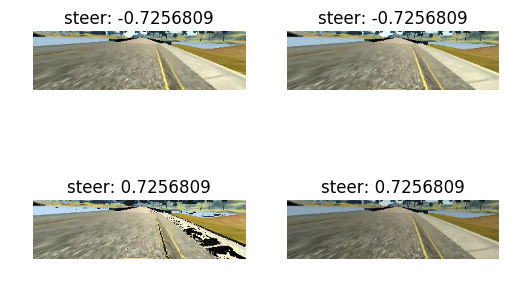

In [9]:
l = 25
plot_imgArr([*X[l:l+2],brightness(X[l]), brightness(X[l+1]) ], label=[*y[l:l+2], -y[l], -y[l+1]]) ## Print olny 4 images

Convert to float and add dimension for the labels. 
Also normalize the RGB values. 

(90, 320)


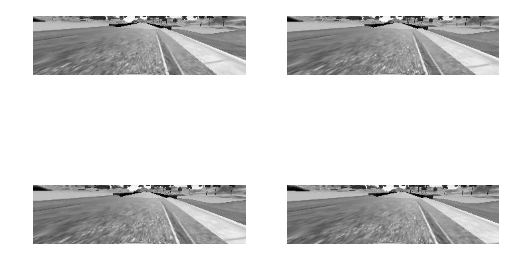

(9351, 90, 320, 1)
(9351, 1)


In [10]:
import cv2
X = np.asarray(X).astype('float32')
X_norm = []
for img in X:
    norm_image = cv2.cvtColor( brightness(img), cv2.COLOR_RGB2GRAY )
    img = cv2.normalize(norm_image, dst=img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    if random.choice([True, False]):
        norm_image = np.add(img, random.uniform(-0.3, 0.3))
    
    X_norm.append(norm_image)

plot_imgArr(X_norm[l:l+4], gray=True)
X = np.asarray(X_norm)
X = X.reshape((X.shape[0],X.shape[1],X.shape[2],1))
y = np.asarray(y).astype('float32')
y = y.reshape((y.shape[0],1))
print(X.shape)
print(y.shape)

From the images we can see that the normalization clears the image.

Now using sklearn tools shuffle and get the validation data.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X,y = shuffle(X,y)
#plot_imgArr(X[100:104], label=y[100:104])

In [12]:
X, X_val, y, y_val = train_test_split(X, y, random_state=0, test_size=0.2)

## Naive implementation:

In this implementation I want to measure the influence of the preprocessing in the behaviour of the network.
For this Keras will be fetching the data I have stored of 4 laps in the simulator.

In [13]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
#from keras.utils.visualize_util import plot
# Current shape: 90x320x3

# Instantiate a Sequential model
model = Sequential()
# Add first convolution layer

# 

model.add(Convolution2D(1,1,1, border_mode='same', input_shape=(X.shape[1],X.shape[2],X.shape[3]), dim_ordering='tf'))
# shape ()
model.add(Convolution2D(24, 5, 5, border_mode='valid', activation='tanh'))
model.add(MaxPooling2D((2,2),(2,2),'valid'))
model.add(Dropout(0.5))

model.add(Convolution2D(36, 5, 5, border_mode='valid', activation='tanh'))
model.add(MaxPooling2D((2,2),(2,2),'valid'))
model.add(Dropout(0.5))

model.add(Convolution2D(48, 3, 3, border_mode='valid', activation='tanh'))
model.add(MaxPooling2D((2,2),(2,2),'valid'))
model.add(Dropout(0.5))

model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='tanh'))
model.add(MaxPooling2D((2,2),(2,2),'valid'))
model.add(Dropout(0.5))

#model.add(Convolution2D(14, 10, 10, border_mode='valid', activation='tanh'))
#model.add(MaxPooling2D((4,4),(4,4),'valid'))
#model.add(Dropout(0.75))


#model.add(Convolution2D(28, 7, 7, border_mode=er_mode='valid', activation='tanh'))
#model.add(MaxPooling2D((2,2),(2,2),'valid'))
#model.add(Dropout(0.75))

model.add(Flatten())
model.add(Dense(1164, activation='tanh'))
model.add(Dense(100,activation='tanh'))
model.add(Dense(50,activation='tanh'))
model.add(Dense(10,activation='tanh'))
model.add(Dense(1,activation='tanh'))
model.summary()
# TODO

#plot(model, to_file='model.png')

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 90, 320, 1)    2           convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 86, 316, 24)   624         convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 43, 158, 24)   0           convolution2d_2[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 43, 158, 24)   0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [14]:
from keras.optimizers import Adam
adam_opt = Adam(lr=0.0001 )
model.compile(loss='mean_squared_error',optimizer=adam_opt)
log = model.fit(X, y,batch_size=40, nb_epoch=12, verbose=1, validation_data=(X_val, y_val))

Train on 7480 samples, validate on 1871 samples
Epoch 1/12
7480/7480 [==============================] - 25s - loss: 0.0520 - val_loss: 0.0527
Epoch 2/12
7480/7480 [==============================] - 24s - loss: 0.0347 - val_loss: 0.0751
Epoch 3/12
7480/7480 [==============================] - 23s - loss: 0.0308 - val_loss: 0.0403
Epoch 4/12
7480/7480 [==============================] - 23s - loss: 0.0289 - val_loss: 0.0364
Epoch 5/12
7480/7480 [==============================] - 24s - loss: 0.0269 - val_loss: 0.0308
Epoch 6/12
7480/7480 [==============================] - 23s - loss: 0.0253 - val_loss: 0.0307
Epoch 7/12
7480/7480 [==============================] - 23s - loss: 0.0238 - val_loss: 0.0413
Epoch 8/12
7480/7480 [==============================] - 23s - loss: 0.0231 - val_loss: 0.0277
Epoch 9/12
7480/7480 [==============================] - 23s - loss: 0.0218 - val_loss: 0.0265
Epoch 10/12
7480/7480 [==============================] - 23s - loss: 0.0206 - val_loss: 0.0217
Epoch 11/12

Save the Model and Data

In [15]:
open("model.json", "w").write(model.to_json())
model.save_weights("model.h5")

In [16]:
# test in the data from the autonomous mode
dbg_imgs = glob("*.png")
dX = []
dy = []
print(len(dbg_imgs))
i= 5
for img in dbg_imgs:
    dX.append(np.asarray(Image.open(img)))
    dy.append(float(img.replace(".png", "")))

sli = np.asarray(dX[i:i+4])
pred = model.predict(sli)
lp = list(map(str, pred))
## TODO: is the image returned by the simulation in the same color space?
## TODO: Debug the Drive.py script to check if there is the problem with the prediciton and not in the network.
print(dy[i:i+4])
print(lp)
plot_imgArr(dX[i:i+4],dy[i:i+4], lp)

0


Exception: Error when checking : expected convolution2d_input_1 to have 4 dimensions, but got array with shape (0, 1)

Plot some images and the predicted steering angle for a quick comparison.

In [ ]:
l= 150
pred = model.predict(X[l:l+4])
sample = X[l:l+4]
sample = sample.reshape(sample.shape[0],sample.shape[1],sample.shape[2] )
plot_imgArr(sample,y[l:l+4], pred, gray=True)
pred

I was getting a bad result in my training, the loss was not being modified, then the learning rate and the batch size were modified. The specific result can be consulted in:
https://github.com/yhoazk/CarND-Behavioral-Cloning-P3/blob/5dadaf1ab68a706e51c5961282140a714a9500ce/ExploreAndPreprocessData.ipynb

The results changed when I changed the activation function from relu to tanh

### Learning Note:

As our data contains a lot of zeros as expected output, the Relu units "die". This means that they are never activated.
Here is an excerpt from Stanfords course on neural networks:

```
"Unfortunately, ReLU units can be fragile during training and can "die". For example, a large gradient flowing through a ReLU neuron could cause the weights to update in such a way that the neuron will never activate on any datapoint again. If this happens, then the gradient flowing through the unit will forever be zero from that point on. That is, the ReLU units can irreversibly die during training since they can get knocked off the data manifold. For example, you may find that as much as 40% of your network can be "dead" (i.e. neurons that never activate across the entire training dataset) if the learning rate is set too high. With a proper setting of the learning rate this is less frequently an issue."
``` [http://cs231n.stanford.edu/]


#### Run the simulator:
To run the simulator w/o the GPU set  CUDA_VISIBLE_DEVICES to nothing i.e.: export  CUDA_VISIBLE_DEVICES=

In [ ]:
import subprocess
subprocess.Popen([SIMULATOR_DIR + "Default Linux desktop Universal.x86_64"])